# Results

Users were divided into monthly cohorts. Number of logins, org_id, and cohort number were the strongest predictors of whether or not a user adopted. Further analysis should be made of:
- the number of logins above which a user becomes more likely to adopt
- the organizations that are most likely to adopt, what is unique about these organizations, and what is unique about how these organizations use the product
- the cohort numbers that are most likely to adopt, what is unique about these cohorts, and what is unique about how these cohorts use the product


In [515]:
%matplotlib inline

from joblib import load
import itertools
import json
import os
import random

from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# scikit-learn
import sklearn
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, \
    f1_score, fbeta_score, log_loss, make_scorer, precision_recall_fscore_support, \
    precision_score, precision_recall_curve, recall_score
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# Models
from xgboost import XGBClassifier

# NLP
import gc
import re
import string
import operator
from collections import defaultdict


# Configure options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state = 11

random.seed(random_state)
np.random.seed(random_state)

In [516]:
from data_exploration.data_visualization import histogram_grid, plot_missing_variable_count, \
plot_variable_dists_by_class_and_dataset

from data_preparation.data_preparation import check_missing_values, add_dummies, add_decomposed_date_variables, \
impute_missing, find_mislabeled

In [517]:
root = '/home/jovyan/work/Documents/relax_challenge'
os.listdir(root)

['.bash',
 'takehome_users.csv',
 'relax_data_science_challenge.pdf',
 'data_preparation',
 'README.md',
 'predicting_user_adoption.ipynb',
 '.dockerignore',
 '.gitignore',
 '.ipynb_checkpoints',
 'takehome_user_engagement.csv',
 '.git',
 'conda_jupyter_notebook',
 'data_exploration',
 '.idea']

# Data preparation

In [518]:
users = pd.read_csv(root + "/takehome_users.csv", encoding="ISO-8859-1")
ueng = pd.read_csv(root + "/takehome_user_engagement.csv", encoding="ISO-8859-1")


In [519]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [520]:
ueng

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [521]:
def check_duplicates(df):
    for column in df.columns:
        duplicated = df[df[column].duplicated()]
        if len(duplicated) > 0:
            print(column, len(duplicated), len(duplicated) / len(df) * 100)

check_duplicates(users)

creation_time 4 0.03333333333333333
name 645 5.375
email 20 0.16666666666666669
creation_source 11995 99.95833333333334
last_session_creation_time 3178 26.48333333333333
opted_in_to_mailing_list 11998 99.98333333333333
enabled_for_marketing_drip 11998 99.98333333333333
org_id 11583 96.525
invited_by_user_id 9435 78.625


In [522]:
users[users['email'].duplicated()].sort_values(by='email')

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
3822,3823,2012-11-22 05:51:29,Lane Alfie,AlfieLane@yahoo.com,ORG_INVITE,1.353650e+09,0,0,169,9498.0
9040,9041,2013-01-03 00:53:47,Bach Amanda,AmandaABach@gmail.com,ORG_INVITE,NaN,0,0,377,6208.0
5081,5082,2013-06-25 19:31:11,Tye Jacob,JacobTye@gmail.com,SIGNUP_GOOGLE_AUTH,1.372361e+09,0,0,298,NaN
3605,3606,2013-05-10 08:31:59,Sankt Janina,JaninaSankt@gmail.com,GUEST_INVITE,1.369816e+09,0,0,84,8356.0
11244,11245,2014-01-17 18:05:15,Neudorf Kerstin,KerstinNeudorf@gmail.com,SIGNUP,1.389982e+09,1,1,68,NaN
4955,4956,2013-01-28 23:21:34,Mueller Klaus,KlausMueller@gustr.com,GUEST_INVITE,1.359415e+09,1,0,19,3225.0
6432,6433,2014-05-09 10:31:42,Kappel Kristin,KristinKappel@yahoo.com,SIGNUP,1.399804e+09,1,1,202,NaN
6536,6537,2014-05-09 00:19:37,Bertelsen Lærke,LaerkeMBertelsen@gmail.com,PERSONAL_PROJECTS,NaN,1,1,127,NaN
7257,7258,2013-05-14 20:04:00,Nørgaard Lasse,LasseLNrgaard@gmail.com,ORG_INVITE,NaN,0,0,35,1904.0
11905,11906,2014-04-14 21:24:59,Duerr Leonie,LeonieDuerr@gmail.com,ORG_INVITE,1.401917e+09,0,0,200,190.0


In [523]:
# Looks like these users signed up twice
users[users['email'] == 'AlfieLane@yahoo.com']

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1603,1604,2014-02-03 04:48:08,Lane Alfie,AlfieLane@yahoo.com,ORG_INVITE,1.391662e+09,0,0,0,4128.0
3822,3823,2012-11-22 05:51:29,Lane Alfie,AlfieLane@yahoo.com,ORG_INVITE,1.353650e+09,0,0,169,9498.0


In [524]:
# Drop duplicated users for now since there are only 20 of them
users_processed = users[~users['email'].duplicated()]
print(len(users) - len(users_processed))

20


In [525]:
# Lots of missing values for last session. 
check_missing_values(users_processed)
# impute_missing 
# find_mislabeled

last_session_creation_time 3172 26.47746243739566
invited_by_user_id 5571 46.502504173622704


In [526]:
last_login = ueng.sort_values(by='time_stamp').groupby('user_id').agg({
    'time_stamp': 'last',
    'visited': 'sum'
})

In [527]:
# Looks like some users signed up but never logged in
users_with_login = users_processed[~users_processed['last_session_creation_time'].isnull()][['object_id', 'last_session_creation_time']]
print(len(users_with_login), len(last_login))
print(len(users_with_login['object_id'].isin(last_login.index)))
print(len(last_login.index.isin(users_with_login['object_id'])))

8808 8823
8808
8823


In [528]:
# The last login values from users and ueng match up. 
users_last_login_unix = users_processed[['object_id', 'last_session_creation_time']].set_index('object_id').rename_axis('user_id')
last_login['last_session_creation_time'] = pd.to_datetime(last_login['time_stamp']).astype(np.int64) / 1e9

# Create feature from the engagement data
last_login = last_login.rename({'visited': 'num_logins'}, axis=1)

merged = last_login.merge(users_last_login_unix, on='user_id', suffixes=('_user_eng', '_user'))
merged[merged['last_session_creation_time_user_eng'] - merged['last_session_creation_time_user'] != 0]

,time_stamp,num_logins,last_session_creation_time_user_eng,last_session_creation_time_user
user_id,,,,


In [529]:
ueng['dt'] = pd.to_datetime(ueng['time_stamp'])
ueng = ueng.sort_values(by=['user_id', 'dt'])
ueng = ueng.set_index('user_id', drop=False)

def add_cohort_and_period(df, action_dt_column, action_dt_str) -> pd.DataFrame:
    """
    Assumes index is some sort of user_id to group actions by user.
    :param df:
    :param action_dt_column: example - visit, purchase
    :param action_dt_str: example - '%Y-%m'
    :return:
    """
    # create period columns based on action
    df['period'] = df[action_dt_column].apply(lambda x: x.strftime(action_dt_str))

    # determine the user's cohort group based on their first action
    df['cohort'] = df.groupby(level=0)[action_dt_column].min().apply(lambda x: x.strftime(action_dt_str))
    unique_cohorts = df['cohort'].unique()
    cohorts_to_cohort_periods = {
        cohort: cohort_num for cohort_num, cohort in enumerate(unique_cohorts)
    }
    df['cohort_num'] = df.apply(lambda row: cohorts_to_cohort_periods[row['cohort']], axis=1)

    return df

ueng = add_cohort_and_period(ueng, 'dt', '%Y-%m')

# Create is_adopted feature
is_adopted_data = []

def is_adopted(timestamps):
    if len(timestamps) < 3:
        return False
    
    for idx in range(len(timestamps) - 2):
        first_day = timestamps.iloc[idx]
        last_day = timestamps.iloc[idx + 2]
        
        if (last_day - first_day).days > 7:
            continue
        
        days = set([ts.day for ts in timestamps.iloc[idx:idx + 3]])
        if len(days) == 3:
            return True
    
    return False

for user_id in ueng['user_id'].unique():
    timestamps = ueng[ueng['user_id'] == user_id]['dt']
    is_user_adopted = is_adopted(timestamps)
    is_adopted_data.append({'user_id': user_id, 'is_adopted': is_user_adopted})

is_adopted_df = pd.DataFrame(is_adopted_data).set_index('user_id').astype(int) 

users_processed = users_processed.set_index('object_id').rename_axis('user_id').drop(['last_session_creation_time'], axis=1)

In [594]:
all_user_data = is_adopted_df.join([users_processed, ueng[['cohort_num']].groupby(level=0).last(), last_login[['num_logins']]])

print('drop', len(all_user_data) - len(all_user_data[~all_user_data['creation_time'].isnull()]), 'rows')
all_user_data = all_user_data[~all_user_data['creation_time'].isnull()]

all_user_data.loc[:, 'creation_source'] = all_user_data['creation_source'].str.lower()

categorical_features = ['creation_source']
all_user_data, categories = add_dummies(all_user_data, categorical_features)

all_user_data = all_user_data.drop(['creation_time', 'name', 'email', 'creation_source'], axis=1)

drop 15 rows
encoder categories for creation_source [array(['guest_invite', 'org_invite', 'personal_projects', 'signup',
       'signup_google_auth'], dtype=object)]


# Data exploration

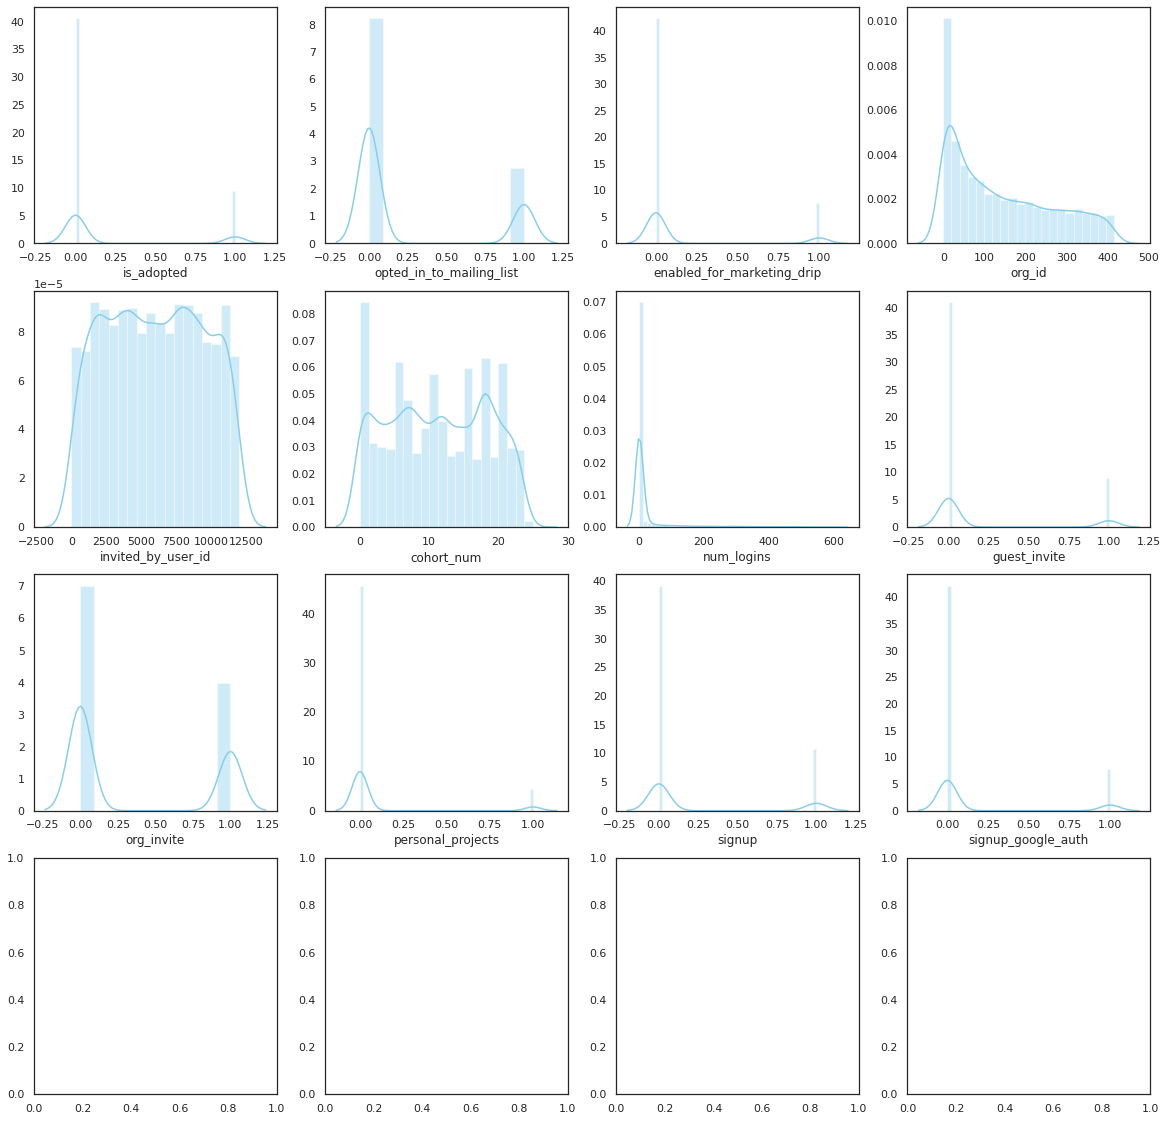

In [595]:
def histogram_grid(df, columns):
    """
    :param df:
    :param columns: Must be numeric type
    :return:
    """
    dim = math.ceil(math.sqrt(len(columns)))
    f, axes = plt.subplots(dim, dim, figsize=(20, 20))
    for ax, feature in zip(axes.flat, columns):
        sns.distplot(df[feature], color="skyblue", ax=ax)

histogram_grid(all_user_data, all_user_data.columns)

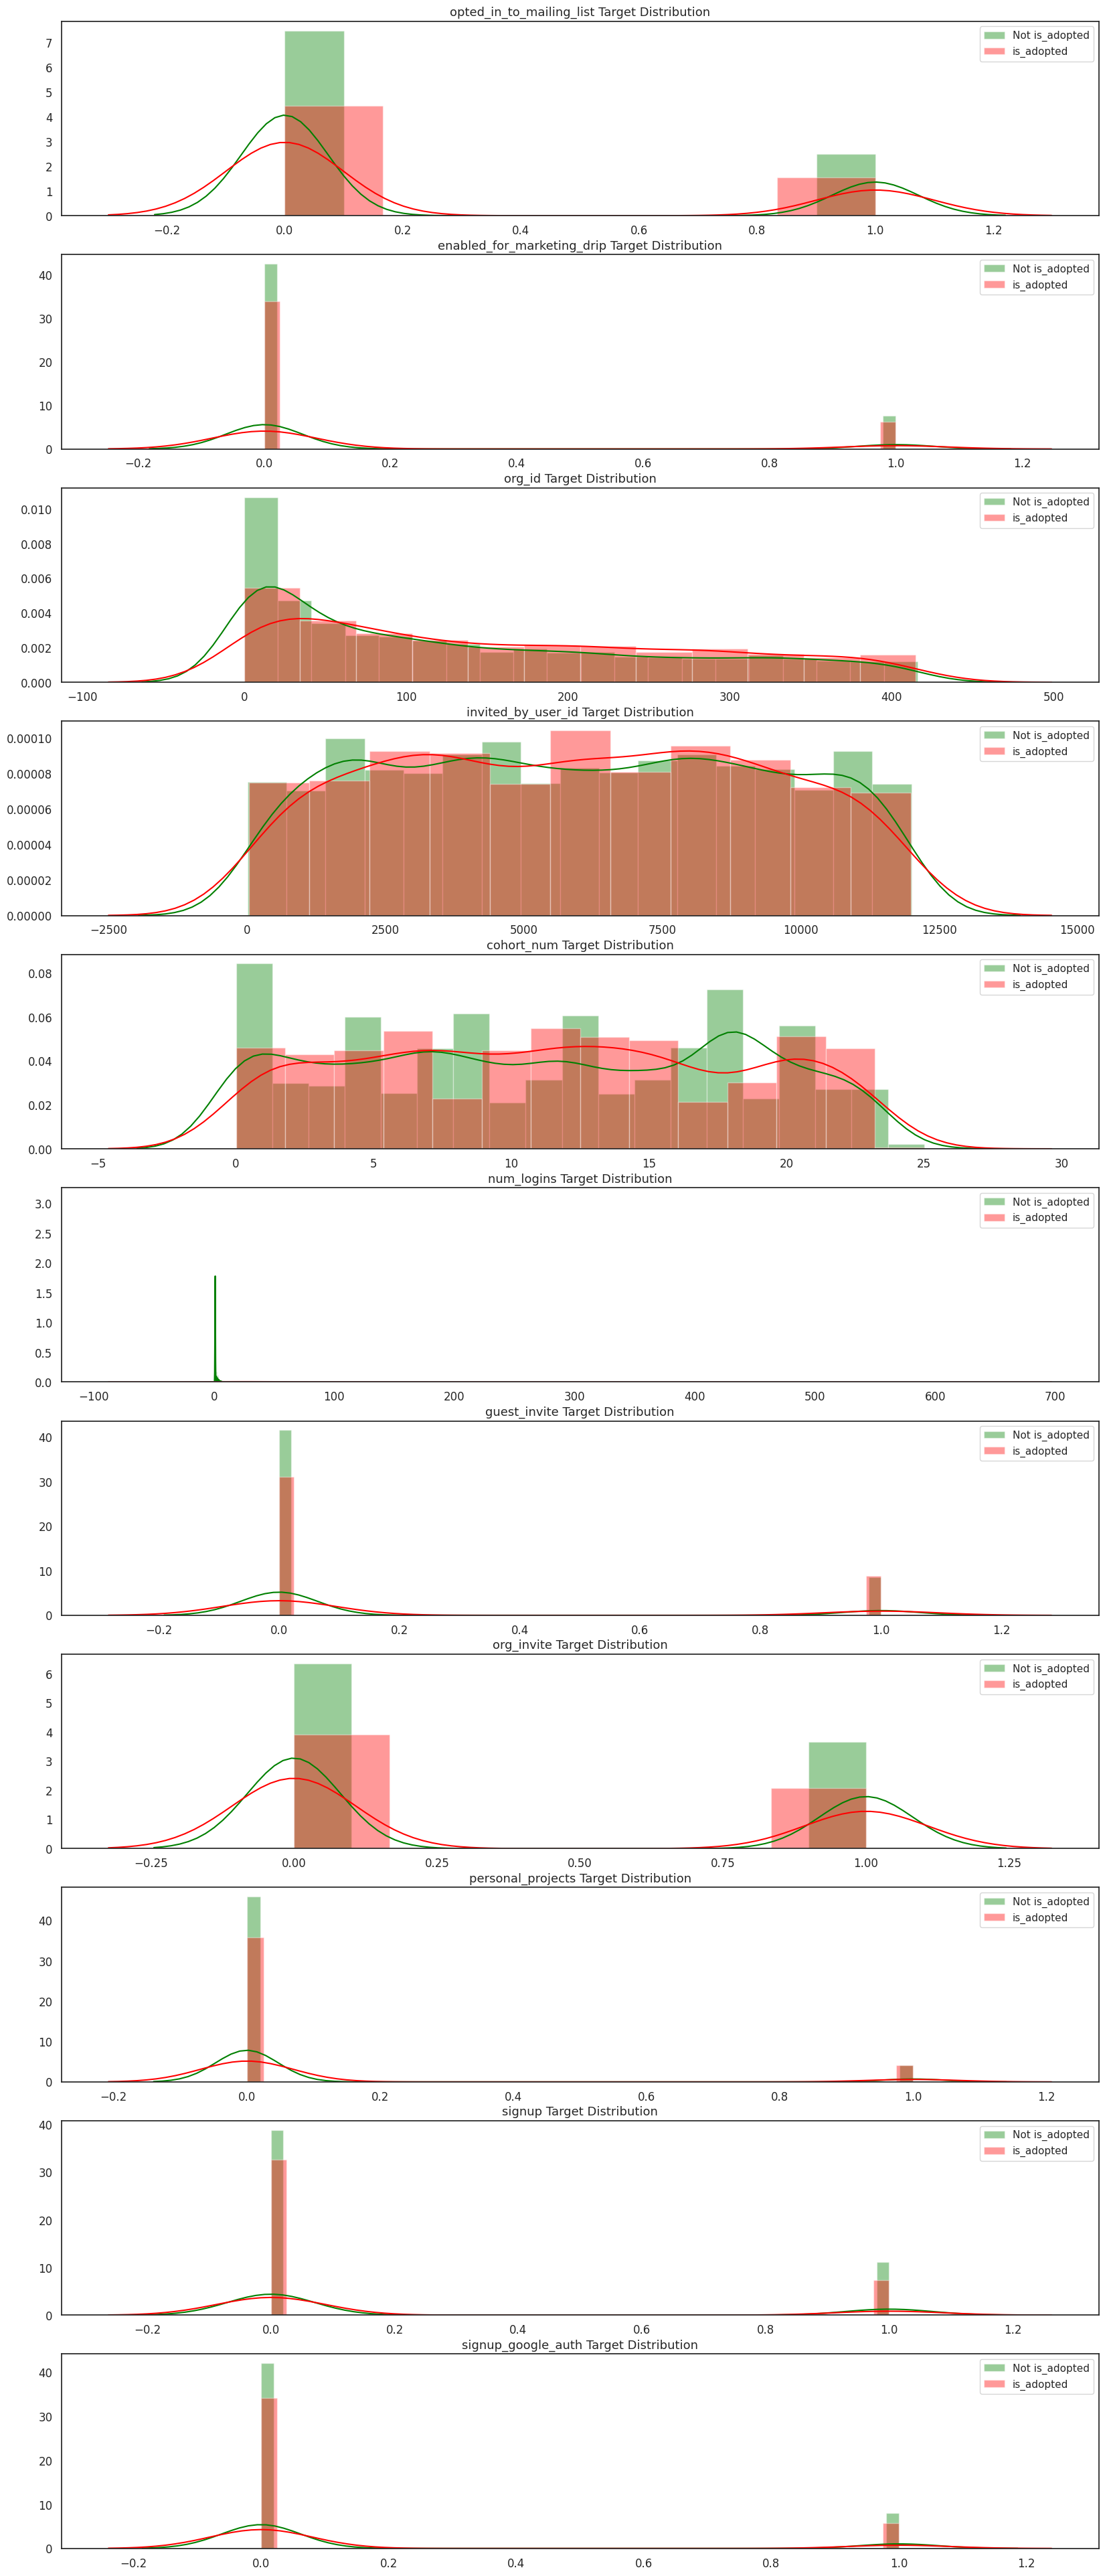

In [596]:
feature_columns = all_user_data.drop(['is_adopted'], axis=1).columns

from typing import List

def plot_variable_dists_by_class(df, target_column: str, features: List[str]):
    has_target: pd.Series = df[target_column] == 1

    fig, axes = plt.subplots(ncols=1, nrows=len(features), figsize=(20, 50), dpi=100)

    for i, feature in enumerate(features):
        sns.distplot(df.loc[~has_target][feature], label=f'Not {target_column}', ax=axes[i], color='green')
        sns.distplot(df.loc[has_target][feature], label=f'{target_column}', ax=axes[i], color='red')

        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].legend()

        axes[i].set_title(f'{feature} Target Distribution', fontsize=13)
    plt.show()


plot_variable_dists_by_class(all_user_data, 'is_adopted', feature_columns)

In [597]:
# Number of logins is highly correlated. Guest invites and personal projects are good predictors
all_user_data.corr()['is_adopted'].sort_values() * 100

signup                         -3.813187
signup_google_auth             -1.649695
org_invite                     -1.500735
invited_by_user_id             -0.148934
enabled_for_marketing_drip      0.455872
opted_in_to_mailing_list        0.764676
cohort_num                      1.415300
personal_projects               2.927871
guest_invite                    5.370750
org_id                          7.810385
num_logins                     62.493558
is_adopted                    100.000000
Name: is_adopted, dtype: float64

In [598]:
all_user_data['invited_by_another_user'] = ~all_user_data['invited_by_user_id'].isnull()
all_user_data['invited_by_another_user'] = all_user_data['invited_by_another_user'].astype(int)
all_user_data = all_user_data.drop(['invited_by_user_id'], axis=1)

In [600]:
all_user_data

,is_adopted,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,cohort_num,num_logins,guest_invite,org_invite,personal_projects,signup,signup_google_auth,invited_by_another_user
user_id,,,,,,,,,,,,
1,0.0,1.0,0.0,11.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1
2,1.0,0.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,94.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1
5,0.0,0.0,0.0,193.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11996,0.0,0.0,0.0,89.0,11.0,1.0,0.0,1.0,0.0,0.0,0.0,1
11997,0.0,0.0,0.0,200.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0
11998,0.0,1.0,1.0,83.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1


# Modeling

In [583]:
from typing import Callable, Dict, List
import time

def classify_pipelines(random_state, pipeline_output_dir, pipelines, loss_func, score_funcs, xtrain, ytrain):
    results = {}
    idx = np.array([num for num in range(len(xtrain))])
    train_idx, valid_idx = train_test_split(idx, random_state=random_state)
    for pipeline_name, pipeline in pipelines.items():
        print('training', pipeline_name)
        results[pipeline_name] = classify(fold_num=0, pipeline_name=pipeline_name, pipeline=pipeline,
                                          pipeline_output_dir=pipeline_output_dir,
                                          loss_func=loss_func,
                                          score_funcs=score_funcs, x=xtrain, y=ytrain, train=train_idx,
                                          test=valid_idx)

    return results

def analyze_classification(pipeline_results):
    results = []
    for pipeline_name, score_data in pipeline_results.items():
        index = [num for num in range(len(score_data))]
        result = pd.DataFrame(pipeline_results[pipeline_name], index=index).to_dict()
        result['pipeline_name'] = pipeline_name
        results.append(result)

    return pd.DataFrame(results).sort_values(by='valid_loss')


# non-default parameters are from https://arxiv.org/pdf/1708.05070.pdf
pipelines = {
    'extra_trees_classifier': Pipeline([
        ('extra_trees_classifier', ExtraTreesClassifier(n_estimators=1000, max_features="log2", criterion="entropy")),
    ]),
    'gradient_boosting_classifier': Pipeline([
        ('gradient_boosting_classifier',
         GradientBoostingClassifier(loss="deviance", learning_rate=.1, n_estimators=500, max_depth=3,
                                    max_features="log2"))
    ]),
    'random_forest_classifier': Pipeline([
        ('random_forest_classifier', RandomForestClassifier(n_estimators=500, max_features=.25, criterion="entropy"))
    ]),
    'knn_classifier': Pipeline([
        ('standard_scaler', StandardScaler()),
        ('knn_classifier', KNeighborsClassifier())
    ]),
    'xgb_classifier': Pipeline([
        ('xgb_classifier', XGBClassifier())
    ])
}

def classify(fold_num, pipeline_output_dir, pipeline_name, pipeline, loss_func, score_funcs: Dict[str, Callable], x, y, train, test):
    """
    Dump pipeline rather than returning it so we don't run out of memory.
    :param fold_num:
    :param pipeline_output_dir:
    :param pipeline_name:
    :param pipeline:
    :param score_funcs:
    :param x:
    :param y:
    :param train:
    :param test:
    :return:
    """
    results = {}
    start = time.time()
    pipeline_fold = clone(pipeline)
    pipeline_fold.fit(x[train], y[train])
    train_time = time.time() - start
    results['train_time'] = train_time
    pred_probas = pipeline_fold.predict_proba(x[test])[:, 1]
    preds = np.array([0 if prob < .5 else 1 for prob in pred_probas])
    results['valid_loss'] = loss_func(y[test], pred_probas)

    for score_func_name, score_func in score_funcs.items():
        results[f'valid_{score_func_name}'] = score_func(y[test], preds)

    # pipeline_ext = "pipeline" if pipeline_name == "xgb_classifier" else "joblib"
    pipeline_ext = "joblib"
    pipeline_filepath = f'{pipeline_output_dir}/{pipeline_name}_fold_{fold_num}.{pipeline_ext}'
    results['pipeline_filepath'] = pipeline_filepath
    dump(pipeline_fold, pipeline_filepath)
    return results



def main(xtrain, ytrain):
    random_state = 42
    
    def fbeta2(ytrue, ypred):
        return fbeta_score(ytrue, ypred, beta=2)
        
    score_funcs = {
        'fbeta2': fbeta2
    }
    pipeline_output_dir = "/home/jovyan/work/data/ultimate_challenge/pipelines"

    if not os.path.exists(pipeline_output_dir):
        os.makedirs(pipeline_output_dir, exist_ok=True)

    pipeline_results = classify_pipelines(random_state=random_state,
                                                pipeline_output_dir=pipeline_output_dir,
                                                pipelines=pipelines,
                                                loss_func=log_loss,
                                                score_funcs=score_funcs,
                                                xtrain=xtrain,
                                                ytrain=ytrain)
    
    return pipeline_results


In [638]:
xdf = all_user_data.drop(['is_adopted'], axis=1)
feature_names = xdf.columns
x = xdf.values
y = all_user_data['is_adopted'].values

xtrain, xtest, ytrain, ytest = train_test_split(*[x, y], test_size=.2, stratify=y)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(7046, 11) (1762, 11) (7046,) (1762,)


In [602]:
from sklearn.base import clone
from joblib import dump

pipeline_results = main(xtrain, ytrain)

training extra_trees_classifier
training gradient_boosting_classifier
training random_forest_classifier
training knn_classifier
training xgb_classifier


In [617]:
def get_baselines(y):
    print('random', log_loss(y, np.array([random.uniform(0, 1) for _ in range(len(y))])))
    print('always negative class', log_loss(y, np.array([0 for _ in range(len(y))])))
    print('always positive class', log_loss(y, np.array([1 for _ in range(len(y))])))
    
get_baselines(ytest)

random 1.0158466859898778
always negative class 6.48827184263078
always positive class 28.051153941566287


In [606]:
def analyze_classification(pipeline_results):
    results = [result for result in pipeline_results.values()]
    return pd.DataFrame(results).sort_values(by='valid_loss')

r = analyze_classification(pipeline_results)
r

,train_time,valid_loss,valid_fbeta2,pipeline_filepath
1,1.166620,0.060106,0.921986,/home/jovyan/work/data/ultimate_challenge/pipe...
2,1.961039,0.061449,0.922531,/home/jovyan/work/data/ultimate_challenge/pipe...
4,0.199345,0.070825,0.923529,/home/jovyan/work/data/ultimate_challenge/pipe...
0,3.503253,0.081330,0.881295,/home/jovyan/work/data/ultimate_challenge/pipe...
3,0.031657,1.221695,0.654800,/home/jovyan/work/data/ultimate_challenge/pipe...


In [608]:
r.iloc[2]['pipeline_filepath']

'/home/jovyan/work/data/ultimate_challenge/pipelines/xgb_classifier_fold_0.joblib'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa378b12f60>]],
      dtype=object)

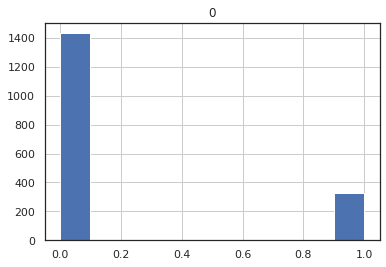

In [613]:
model = load(r.iloc[0]['pipeline_filepath'])
predicted_probas = model.predict(xtest)
predicted_classes = np.array([0 if proba < .5 else 1 for proba in predicted_probas])
pd.DataFrame(predicted_probas).hist()

In [619]:
def get_precision_recall_df(y_actual, y_pred_probas):
    precision, recall, thresholds = precision_recall_curve(y_actual, y_pred_probas)
    df = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1], 'threshold': thresholds}).sort_values(
        by='threshold')
    return df


def plot_precision_recall_threshold(y_actual, y_pred_probas):
    precision, recall, thresholds = precision_recall_curve(y_actual, y_pred_probas)
    precision = precision[:-1]
    recall = recall[:-1]
    df = pd.concat([
        pd.DataFrame({'stat_name': ['precision' for _ in range(len(precision))],
                      'stat_value': precision,
                      'threshold': thresholds}),
        pd.DataFrame({'stat_name': ['recall' for _ in range(len(precision))],
                      'stat_value': recall,
                      'threshold': thresholds})
    ])

    ax = sns.lineplot(y=df['stat_value'], x=df['threshold'], hue=df['stat_name'],
                      palette={'precision': 'red', 'recall': 'blue'})
    ax.set_title('Precision/Recall per Threshold')
    return ax


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="lightgrey" if cm[i, j] > thresh else "darkgrey")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.98742138 0.01257862]
 [0.05740181 0.94259819]]


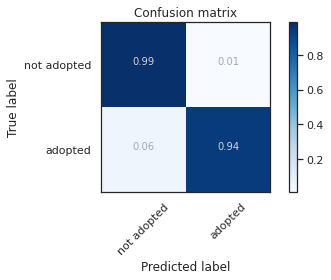

In [624]:
plot_confusion_matrix(confusion_matrix(ytest, predicted_probas), ['not adopted', 'adopted'], normalize=True)

In [632]:
import shap

def get_xgb_shap(pipeline_results, xtrain: np.array, feature_names):
    """
    Use SHAP: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
    :param pipeline_results:
    :param xtrain:
    :param feature_names:
    :return:
    """
    explainer = shap.TreeExplainer(pipeline_results._final_estimator)
    shap_values = explainer.shap_values(xtrain[:1000])
    shap.initjs()
    # shap.force_plot(explainer.expected_value, shap_values[0,:], xtrain[0,:], feature_names=xdf.columns)
    return pd.DataFrame({'shap_value': shap_values[0, :], 'feature_names': feature_names}).sort_values(by='shap_value',
                                                                                                       ascending=False)


explainer = shap.TreeExplainer(model._final_estimator)
shap_values = explainer.shap_values(xtest)


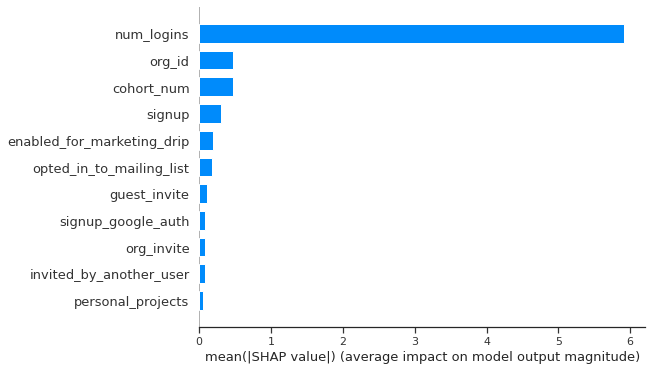

In [634]:
shap.summary_plot(shap_values, xtest, plot_type="bar",  feature_names=x_names)

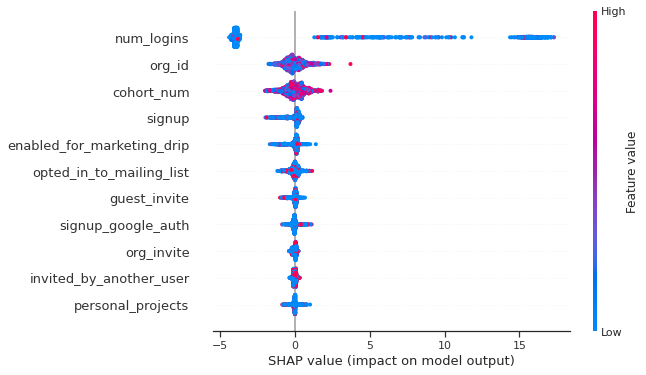

In [639]:
shap.summary_plot(shap_values, xtest, feature_names=feature_names)

In [654]:
xtestdf = pd.DataFrame(xtest, columns=feature_names)

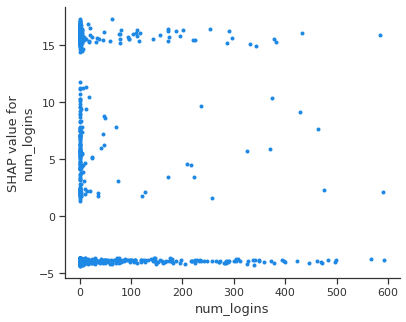

In [663]:
shap.dependence_plot("num_logins", shap_values, xtestdf, interaction_index=None)

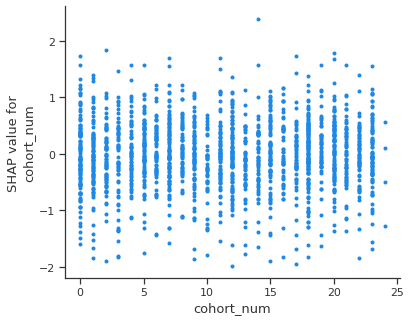

In [656]:
shap.dependence_plot("cohort_num", shap_values, xtestdf, interaction_index=None)

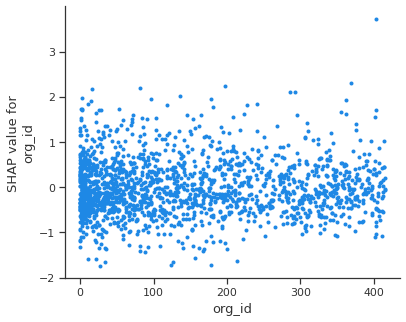

In [657]:
shap.dependence_plot("org_id", shap_values, xtestdf, interaction_index=None)